# 序列模型

序列数据
- 实际中很多数据是有时序结构的
- 电影的评价随时间变化而变化
  - 拿奖后评分上升，直到奖项被忘记
  - 看了很多好电影后，人们的期望变高
  - 季节性：贺岁片、暑期档
  - 导演、演员的负面报道导致评分变低

自回归模型

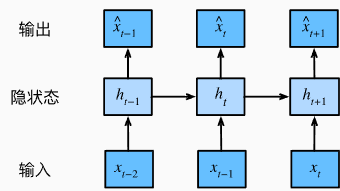

总结
- 时序模型中，当前数据和之前的观测数据相关
- 自回归模型使用自身过去数据来预测未来
- 马尔可夫模型假设当前只跟最近少数数据相关，从而简化模型
- 潜变量模型使用潜变量来概率历史信息

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l
from torch import nn

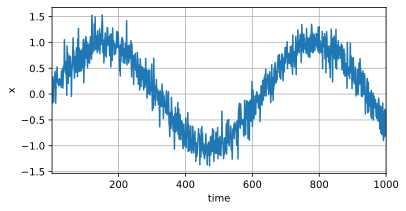

In [2]:
#使用正弦函数和一些可加性噪声来生成序列数据
T = 1000
time = torch.arange(1, T+1, dtype= torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim= [1, 1000],  figsize= (6,3))

In [3]:
tau = 4
features = torch.zeros((T- tau, tau))
for i in range(tau):
    features[:, i] = x[i: T- tau + i]
labels = x[tau:].reshape((-1, 1))
#前600个数据作为训练样本
batch_size, n_train = 16, 600
#构建训练器
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), 
                             batch_size, is_train= True)

In [4]:
#使用多层感知机作为训练模型
#两个全连接层＋ReLU激活函数以及平方损失
def init_weights(m):
    """使用Xavier初始化模型权重"""
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

#多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction= 'none')

In [5]:
#训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr= lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            #清空梯度
            trainer.zero_grad()
            #计算损失
            l = loss(net(X), y)
            #对损失求和并反向传播
            l.sum().backward()
            #进行迭代
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net,  train_iter, loss):.4f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.1198
epoch 2, loss: 0.0742
epoch 3, loss: 0.0635
epoch 4, loss: 0.0623
epoch 5, loss: 0.0637


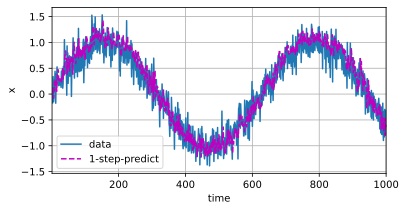

In [6]:
#检测模型预测下一个时间步的能力
onestep_predict = net(features)
d2l.plot([time, time[tau:]], 
        [x.detach().numpy(),  onestep_predict.detach().numpy()], 
        xlabel='time', ylabel='x', legend=['data', '1-step-predict'], xlim= [1, T],
        figsize= (6, 3))

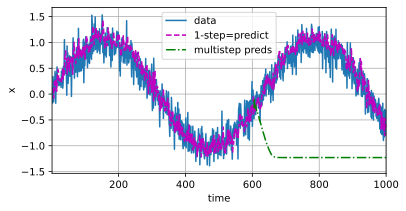

In [7]:
#使用自己的预测结果来预测时序数据
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    #基于前tau个时序数据预测后续数据
    multistep_preds[i] = net(multistep_preds[i- tau: i].reshape((1,-1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_predict.detach().numpy(), 
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
          'x', legend = ['data', '1-step=predict', 'multistep preds'],
          xlim= [1, 1000], figsize= (6, 3))

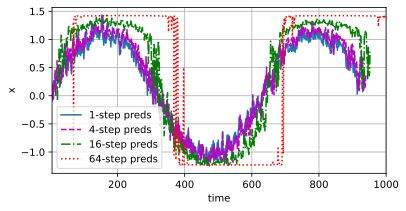

In [8]:
max_steps = 64
features = torch.zeros(T - tau - max_steps + 1, tau + max_steps)
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i -1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps],
         'time', 'x', legend= [f'{i}-step preds'for i in steps], xlim= [5, 1000],
         figsize=(6, 3))